In [1]:
import os
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from pathlib import Path
import keras
from keras import layers
import matplotlib.pyplot as plt
import shutil
import random
import pathlib
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
ruta_datos = "/content/drive/MyDrive/Entrenamientos DL COA 690/Nuevos datos/Conjunto Completo.zip"
ruta_salida = "/content/"
!unzip -qq "{ruta_datos}" -d "{ruta_salida}"

In [4]:
original_dir = pathlib.Path("/content/Conjunto Completo")
new_base_dir = pathlib.Path("/content/")
classes = ["A", "R", "S"]

train_split = 0.8
test_split = 0.2

for category in classes:
    print(f"Processing {category} images...")

    # Obtener los nombres de archivo para la categoría actual
    fnames = [fname for fname in os.listdir(original_dir) if fname.startswith(category)]

    # Obtener el número total de imágenes
    n_images = len(fnames)

    # Mezclar los nombres de archivo al azar
    np.random.seed(0)
    random.shuffle(fnames)

    # Calcular el número de imágenes para cada conjunto
    n_train = int(train_split * n_images)
    n_test = int(test_split * n_images)

    # Dividir los nombres de archivo en conjuntos
    train_fnames = fnames[:n_train]
    test_fnames = fnames[n_train:n_train+n_test]

    # Crear los directorios para los conjuntos
    train_dir = new_base_dir / "train" / category
    test_dir = new_base_dir / "test" / category
    combined_dir = new_base_dir / "combined" / category

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    os.makedirs(combined_dir, exist_ok=True)

    # Copiar las imágenes a los directorios correspondientes
    for fname in train_fnames:
        src_path = original_dir / fname
        dst_path = train_dir / fname
        shutil.copyfile(src_path, dst_path)

    for fname in test_fnames:
        src_path = original_dir / fname
        dst_path = test_dir / fname
        shutil.copyfile(src_path, dst_path)

    # Copiar las imágenes de train y test a combined_dir
    combined_fnames = train_fnames + test_fnames
    for fname in combined_fnames:
        src_path = original_dir / fname
        dst_path = combined_dir / fname
        shutil.copyfile(src_path, dst_path)

print("Done.")


Processing A images...
Processing R images...
Processing S images...
Done.


In [5]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(224, 224),
    batch_size=16)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(224, 224),
    batch_size=16,
    shuffle = False)
total_dataset = image_dataset_from_directory(
    new_base_dir / "combined",
    image_size = (224, 224),
    batch_size = 16
)

Found 534 files belonging to 3 classes.
Found 132 files belonging to 3 classes.
Found 666 files belonging to 3 classes.


In [6]:
# Obtener los datos de entrenamiento y las etiquetas de entrenamiento
X_train = []
y_train = []
for images, labels in train_dataset:
    X_train.append(images.numpy())
    y_train.append(labels.numpy())

X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)

# Obtener los datos de prueba y las etiquetas de prueba
X_test = []
y_test = []
for images, labels in test_dataset:
    X_test.append(images.numpy())
    y_test.append(labels.numpy())

X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

# Obtener los datos combinados y las etiquetas combinadas
X_combined = []
y_combined = []
for images, labels in total_dataset:
    X_combined.append(images.numpy())
    y_combined.append(labels.numpy())

X_combined = np.concatenate(X_combined)
y_combined = np.concatenate(y_combined)


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras import layers

In [9]:
ruta_modelos = "/content/drive/MyDrive/Entrenamientos DL COA 690/Nuevos datos/Modelos optimizados/"
os.chdir(ruta_modelos)

modelo_entrenado = keras.models.load_model("CholletV2.keras")

modelo_2 = Model(inputs=modelo_entrenado.input,outputs=modelo_entrenado.get_layer('dense').output)

modelo_2.summary()

features = modelo_2.predict(X_train)

# Llamar al modelo de Random Forest

rf_model = RandomForestClassifier(random_state = 1)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                           

In [10]:
features.shape

(534, 256)

In [11]:
from sklearn.model_selection import GridSearchCV

# Se define un rango de valores para cada hiperparámetro de interés

estimator_range = [100, 200, 300, 1000]
max_depth_range = [4, 6, 8, 20]

param_grid = [{'n_estimators': estimator_range,
               'max_features': [ 'sqrt', 'auto'],
               'max_depth': max_depth_range,
               'criterion': ['gini', 'entropy']}]

gs = GridSearchCV(estimator = rf_model,
                  param_grid = param_grid,
                  scoring = 'accuracy',
                  cv = 10,
                  n_jobs = -1,
                  refit = True)

gs = gs.fit(features, y_train)
gs.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'sqrt',
 'n_estimators': 200}

In [12]:
pipe_rfc = make_pipeline(StandardScaler(),
                          RandomForestClassifier(criterion = 'gini',
                          max_depth = 8,
                          max_features = 'sqrt',
                          n_estimators = 200,
                          n_jobs = -1,
                          random_state = 1))

In [13]:
X_features = modelo_entrenado.predict(X_combined)

21/21 [==============================] - 1s 43ms/step


Accuracy para el pliegue 0: 0.82 
Accuracy para el pliegue 1: 0.84 
Accuracy para el pliegue 2: 0.79 
Accuracy para el pliegue 3: 0.73 
Accuracy para el pliegue 4: 0.78 
Accuracy para el pliegue 5: 0.85 
Accuracy para el pliegue 6: 0.80 
Accuracy para el pliegue 7: 0.83 
Accuracy para el pliegue 8: 0.92 
Accuracy para el pliegue 9: 0.89 

Mejor pliegue: 8, Accuracy: 0.92
Desviación estándar: (+/-) 0.05

Métricas de desempeño para el mejor pliegue:
              precision    recall  f1-score   support

           0       0.88      0.83      0.86        18
           1       1.00      0.95      0.97        20
           2       0.90      0.96      0.93        28

    accuracy                           0.92        66
   macro avg       0.93      0.92      0.92        66
weighted avg       0.93      0.92      0.92        66



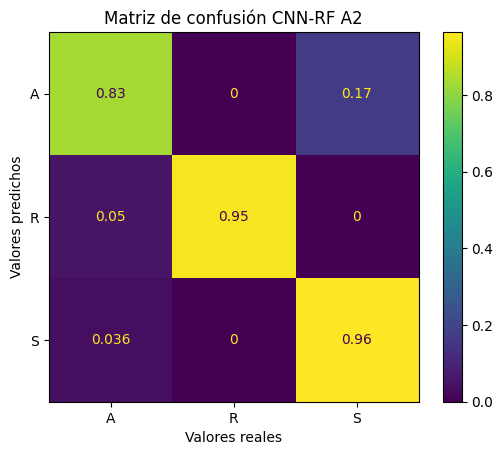

AUC para la clase 0: 0.94
AUC para la clase 1: 0.98
AUC para la clase 2: 0.97


In [14]:
best_accuracy = 0
best_fold = 0
best_auc = 0.0
pliegues = []

# Obtiene las predicciones y el classification report para cada validación
for i, (train_index, test_index) in enumerate(StratifiedKFold(10).split(X_features, y_combined)):
    # Separa los datos en conjuntos de entrenamiento y prueba para la i-ésima validación
    X_train_cv, X_test_cv = X_features[train_index], X_features[test_index]
    y_train_cv, y_test_cv = y_combined[train_index], y_combined[test_index]

    # Entrena el modelo con los datos de entrenamiento
    pipe_rfc.fit(X_train_cv, y_train_cv)

    # Haz predicciones en los datos de prueba
    y_pred = pipe_rfc.predict(X_test_cv)

    # Haz predicciones y calcular la pertenencia para cada clase
    y_pred_proba = pipe_rfc.predict_proba(X_test_cv)

    # Calcula el accuracy para las predicciones
    accuracy = accuracy_score(y_test_cv, y_pred)

    # Calcula el AUC para las predicciones
    auc = roc_auc_score(y_test_cv, y_pred_proba, average = None, multi_class = 'ovr')

    # Actualiza el mejor fold si el accuracy actual es mayor que el anterior
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_fold = i
        best_report = metrics.classification_report(y_test_cv, y_pred)
        etiquetas = classes
        matriz_c = confusion_matrix(y_test_cv, y_pred,
                                    labels = pipe_rfc.classes_,
                                    normalize = 'true' )
        display = ConfusionMatrixDisplay(confusion_matrix = matriz_c,
                                 display_labels = etiquetas)
        best_auc = auc


    # Imprime el accuracy para la i-ésima validación
    print("Accuracy para el pliegue %d: %0.2f " % (i, accuracy))

    #Guardar los ACC de cada pliegue
    pliegues.append(accuracy)

# Imprime el fold con el mejor accuracy
print("\nMejor pliegue: %d, Accuracy: %0.2f" % (best_fold, best_accuracy))
print("Desviación estándar: (+/-) %0.2f" % np.std(pliegues))

# Imprime el classification report para el mejor fold
print("\nMétricas de desempeño para el mejor pliegue:")
print(best_report)

fig, ax = plt.subplots()
display.plot(ax=ax)
ax.set_title("Matriz de confusión CNN-RF A2")
ax.set_xlabel("Valores reales")
ax.set_ylabel("Valores predichos")
plt.show()

# Imprime el AUC para cada clase en el mejor fold
for clase, auc_score in zip(pipe_rfc.classes_, best_auc):
    auc_formatted = "{:.2f}".format(auc_score)
    print(f"AUC para la clase {clase}: {auc_formatted}")
